In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp

import bayesflow as bf
from bayesflow.amortizers import AmortizedPointEstimator
from bayesflow.benchmarks import Benchmark
from bayesflow.helper_networks import ConfigurableMLP
from bayesflow.simulation import GenerativeModel, Prior, Simulator
from bayesflow.summary_networks import DeepSet

np.random.seed(2024)


/opt/anaconda3/envs/bayesflow/lib/python3.11/site-packages/bayesflow/trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
#先验分布
def batch_prior_fun(batch_size):
    dist = tfp.distributions.Normal(0, 1.0)
    return dist.sample((batch_size, 1))

def batch_simulator_fun(theta, n_obs=1000):
    # theta 是从 prior_fun 中采样的参数 μ
    # 生成数据服从 N(μ, 1)，每个 μ 生成 n_obs 个观测值
    return tf.random.normal((theta.shape[0], n_obs), mean=theta, stddev=1)[:, :, None]

prior = Prior(batch_prior_fun=batch_prior_fun)
simulator = Simulator(batch_simulator_fun=batch_simulator_fun)
generative_model = GenerativeModel(prior=prior, simulator=simulator)

INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 1)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 1000, 1)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


In [3]:
def config(forward_dict):
    """Helper function for posterior configuration."""
    input_dict = {}
    input_dict["parameters"] = forward_dict["prior_draws"]
    input_dict["summary_conditions"] = forward_dict["sim_data"]
    return input_dict

In [4]:
benchmark = Benchmark("gaussian_linear", mode="posterior", sim_kwargs={"n_obs": 10}) #？？

summary_dim = 10
summary_net = DeepSet(summary_dim)

inference_net = ConfigurableMLP(input_dim=summary_dim, output_dim=1, dropout_rate=0.1)

amortizer = AmortizedPointEstimator(inference_net, summary_net=summary_net, norm_ord=1) #表示推断的维度是1

INFO:root:Performing 2 pilot runs with the gaussian_linear model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 10)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 10, 10)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


In [69]:
trainer = bf.trainers.Trainer(amortizer=amortizer, configurator=config, generative_model=generative_model)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [70]:
%%time
h = trainer.train_online(2, 500, batch_size=32)

Training epoch 2: 100%|██████████| 500/500 [00:27<00:00, 18.42it/s, Epoch: 2, Iter: 500,Loss: 0.037,Avg.Loss: 0.043,LR: 1.24E-09]

CPU times: user 2min 56s, sys: 58.5 s, total: 3min 55s
Wall time: 54.2 s


In [71]:
# Quick point estimates can be obtained by simply calling the .estimate() method
num_test = 1000
test_param_fun = lambda batch_size: tf.ones((batch_size, 1)) * 0  # set theta to 1/3 for all simulations
test_model = GenerativeModel(prior=Prior(batch_prior_fun=test_param_fun), simulator=simulator)
test_data = config(test_model(num_test))

estimates = amortizer.estimate(test_data)[:, 0]

INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 1)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 1000, 1)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


In [72]:

def bayes_estimator(Z, mu_0=1, m=1, sigma_0=1):
    """
    实现贝叶斯估计器，根据先验和观测数据计算后验分布，并从中采样。
    
    参数：
    - Z: 输入数据，形状为 TensorShape([n, 1])。
    - mu_0: 先验均值 (prior mean)。
    - m: 先验虚拟样本量。
    - sigma_0: 先验标准差。
    
    返回：
    - posterior_samples: 从后验分布中采样的 1000 个样本。
    """
    # 确保 Z 是 TensorFlow 张量
    Z = tf.convert_to_tensor(Z, dtype=tf.float32)

    # 计算观测数据的均值 y_bar 和数量 n
    y_bar = tf.reduce_mean(Z)  # 计算均值
    n = tf.cast(Z.shape[0], tf.float32)  # 转换 n 为浮点数

    # 计算后验分布的参数
    posterior_mean = tf.cast((m * mu_0 + n * y_bar) / (m + n), tf.float32)  # 后验均值
    posterior_stddev = tf.cast(sigma_0 / tf.sqrt(m + n), tf.float32)  # 后验标准差

    # 定义后验分布
    dist = tfp.distributions.Normal(loc=posterior_mean, scale=posterior_stddev)

    # 从后验分布中采样
    posterior_samples = dist.sample(1000).numpy()

    return posterior_samples

# summary_conditions = tf.reshape(test_data["summary_conditions"], [-1, 1])
summary_conditions = tf.reshape(test_data["summary_conditions"][:, 0, :], [-1, 1])

# 调用 bayes_estimator
reference = bayes_estimator(summary_conditions)

# reference = bayes_estimator(test_data["summary_conditions"])

/var/folders/xh/6yy1qtv504b1yv27rltr5cdc0000gn/T/ipykernel_27462/171379402.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(estimates, label="Neural Bayes estimator", shade=True)


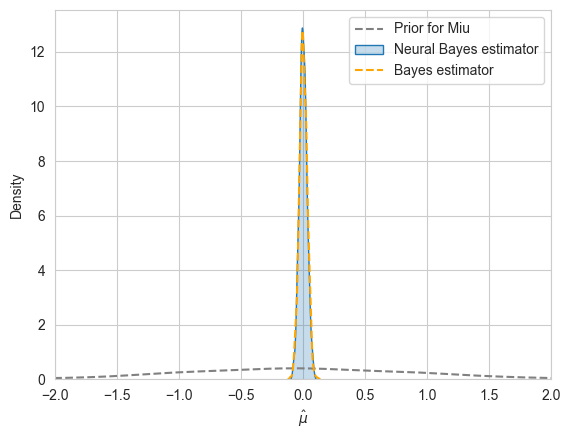

In [73]:
prior_dist = tfp.distributions.Normal(0.0, 1.0)

# 从该分布中采样 1000 个点
prior_samples = prior_dist.sample(1000).numpy()

# 设置 x 轴范围
plt.xlim(-2, 2)

sns.kdeplot(prior_samples, label="Prior for Miu", color="grey", linestyle="--")
sns.kdeplot(estimates, label="Neural Bayes estimator", shade=True)
sns.kdeplot(reference, label="Bayes estimator",color = "orange", linestyle="--")
plt.xlabel(r"$\hat\mu$")
_ = plt.legend()

In [48]:
# Quick point estimates can be obtained by simply calling the .estimate() method
num_test = 1000
test_param_fun = lambda batch_size: tf.ones((batch_size, 1)) * 1/ 3  # set theta to 1/3 for all simulations
test_model = GenerativeModel(prior=Prior(batch_prior_fun=test_param_fun), simulator=simulator)
test_data = config(test_model(num_test))

INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 1)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 1000, 1)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


In [49]:
%%time
estimates = amortizer.estimate(test_data)[:, 0]

CPU times: user 2.13 s, sys: 1.1 s, total: 3.22 s
Wall time: 773 ms


In [56]:

def bayes_estimator(Z, mu_0=1, m=1, sigma_0=1):
    """
    实现贝叶斯估计器，根据先验和观测数据计算后验分布，并从中采样。
    
    参数：
    - Z: 输入数据，形状为 TensorShape([n, 1])。
    - mu_0: 先验均值 (prior mean)。
    - m: 先验虚拟样本量。
    - sigma_0: 先验标准差。
    
    返回：
    - posterior_samples: 从后验分布中采样的 1000 个样本。
    """
    # 确保 Z 是 TensorFlow 张量
    Z = tf.convert_to_tensor(Z, dtype=tf.float32)

    # 计算观测数据的均值 y_bar 和数量 n
    y_bar = tf.reduce_mean(Z)  # 计算均值
    n = tf.cast(Z.shape[0], tf.float32)  # 转换 n 为浮点数

    # 计算后验分布的参数
    posterior_mean = tf.cast((m * mu_0 + n * y_bar) / (m + n), tf.float32)  # 后验均值
    posterior_stddev = tf.cast(sigma_0 / tf.sqrt(m + n), tf.float32)  # 后验标准差

    # 定义后验分布
    dist = tfp.distributions.Normal(loc=posterior_mean, scale=posterior_stddev)

    # 从后验分布中采样
    posterior_samples = dist.sample(1000).numpy()

    return posterior_samples

# summary_conditions = tf.reshape(test_data["summary_conditions"], [-1, 1])
summary_conditions = tf.reshape(test_data["summary_conditions"][:, 0, :], [-1, 1])

# 调用 bayes_estimator
reference = bayes_estimator(summary_conditions)

# reference = bayes_estimator(test_data["summary_conditions"])

In [57]:
# 展开为n，1
# summary_conditions = tf.reshape(test_data["summary_conditions"], [-1, 1])

/var/folders/xh/6yy1qtv504b1yv27rltr5cdc0000gn/T/ipykernel_27462/171379402.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(estimates, label="Neural Bayes estimator", shade=True)


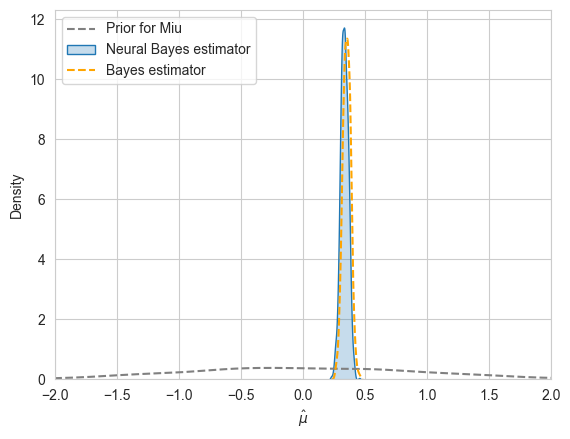

In [58]:
prior_dist = tfp.distributions.Normal(0.0, 1.0)

# 从该分布中采样 1000 个点
prior_samples = prior_dist.sample(1000).numpy()

# 设置 x 轴范围
plt.xlim(-2, 2)

sns.kdeplot(prior_samples, label="Prior for Miu", color="grey", linestyle="--")
sns.kdeplot(estimates, label="Neural Bayes estimator", shade=True)
sns.kdeplot(reference, label="Bayes estimator",color = "orange", linestyle="--")
plt.xlabel(r"$\hat\mu$")
_ = plt.legend()

In [62]:
# Quick point estimates can be obtained by simply calling the .estimate() method
num_test = 1000
test_param_fun = lambda batch_size: tf.ones((batch_size, 1)) * -1  # set theta to 1/3 for all simulations
test_model = GenerativeModel(prior=Prior(batch_prior_fun=test_param_fun), simulator=simulator)
test_data = config(test_model(num_test))

estimates = amortizer.estimate(test_data)[:, 0]

INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 1)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 1000, 1)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


In [63]:

def bayes_estimator(Z, mu_0=1, m=1, sigma_0=1):
    """
    实现贝叶斯估计器，根据先验和观测数据计算后验分布，并从中采样。
    
    参数：
    - Z: 输入数据，形状为 TensorShape([n, 1])。
    - mu_0: 先验均值 (prior mean)。
    - m: 先验虚拟样本量。
    - sigma_0: 先验标准差。
    
    返回：
    - posterior_samples: 从后验分布中采样的 1000 个样本。
    """
    # 确保 Z 是 TensorFlow 张量
    Z = tf.convert_to_tensor(Z, dtype=tf.float32)

    # 计算观测数据的均值 y_bar 和数量 n
    y_bar = tf.reduce_mean(Z)  # 计算均值
    n = tf.cast(Z.shape[0], tf.float32)  # 转换 n 为浮点数

    # 计算后验分布的参数
    posterior_mean = tf.cast((m * mu_0 + n * y_bar) / (m + n), tf.float32)  # 后验均值
    posterior_stddev = tf.cast(sigma_0 / tf.sqrt(m + n), tf.float32)  # 后验标准差

    # 定义后验分布
    dist = tfp.distributions.Normal(loc=posterior_mean, scale=posterior_stddev)

    # 从后验分布中采样
    posterior_samples = dist.sample(1000).numpy()

    return posterior_samples

# summary_conditions = tf.reshape(test_data["summary_conditions"], [-1, 1])
summary_conditions = tf.reshape(test_data["summary_conditions"][:, 0, :], [-1, 1])

# 调用 bayes_estimator
reference = bayes_estimator(summary_conditions)

# reference = bayes_estimator(test_data["summary_conditions"])

/var/folders/xh/6yy1qtv504b1yv27rltr5cdc0000gn/T/ipykernel_27462/171379402.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(estimates, label="Neural Bayes estimator", shade=True)


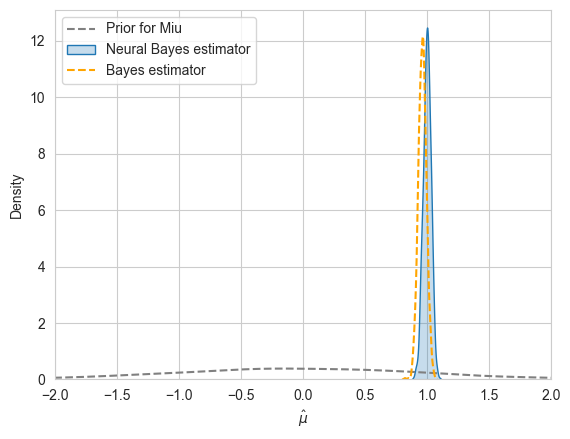

In [64]:
prior_dist = tfp.distributions.Normal(0.0, 1.0)

# 从该分布中采样 1000 个点
prior_samples = prior_dist.sample(1000).numpy()

# 设置 x 轴范围
plt.xlim(-2, 2)

sns.kdeplot(prior_samples, label="Prior for Miu", color="grey", linestyle="--")
sns.kdeplot(estimates, label="Neural Bayes estimator", shade=True)
sns.kdeplot(reference, label="Bayes estimator",color = "orange", linestyle="--")
plt.xlabel(r"$\hat\mu$")
_ = plt.legend()